In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

from patrec.utils import plot_series

In [ ]:
import json
import numpy as np
from scipy import stats
from typing import Dict, Union, Tuple
from statsmodels.tsa.stattools import adfuller

def get_series_stats(series: np.ndarray) -> Dict[str, float]:
    """Analyze time-series properties with efficient calculations"""
    if len(series) < 2:
        return {'noise_level': 0, 'stationarity': 0, 'length': len(series)}
    
    # Efficient noise estimation using first differences
    noise_level = np.std(np.diff(series)) / (np.std(series) + 1e-10)
    
    # Stationarity test with optimized parameters
    _, p_value, _, _, _ = adfuller(series, maxlag=min(10, len(series)//5))
    
    return {
        'noise_level': float(noise_level),
        'stationarity': float(p_value),
        'length': len(series)
    }

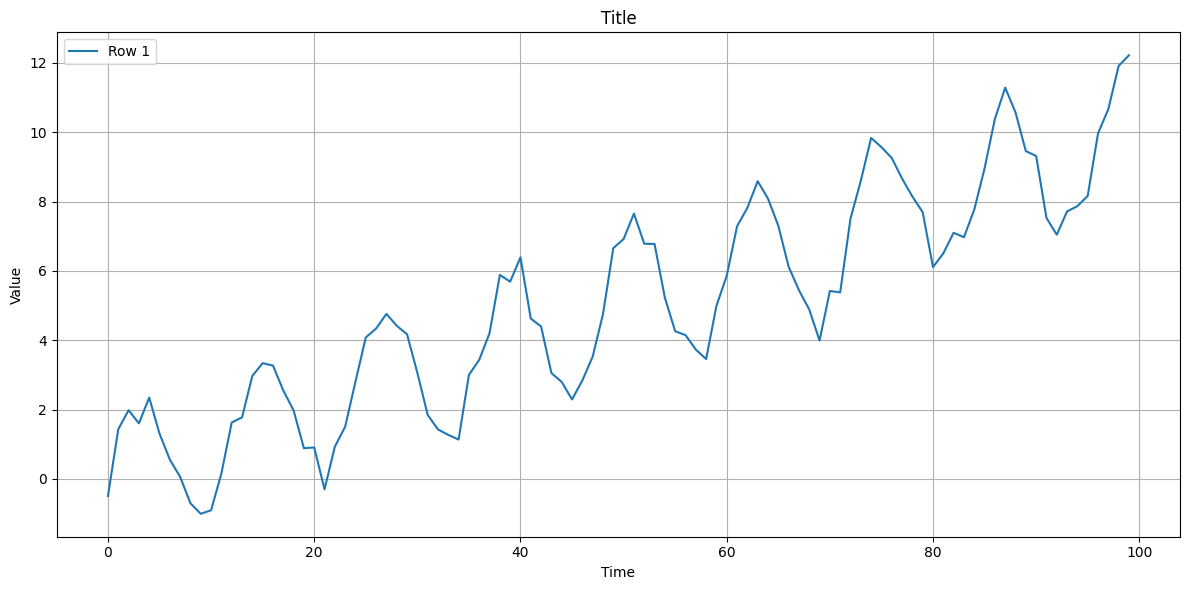

In [3]:
np.random.seed(25)
trend = np.random.randn(100) * 0.1 + np.linspace(0, 10, 100)  # Linear trend + noise
seasonal = 2 * np.sin(2 * np.pi * np.arange(100) / 12) # Yearly seasonality
residuals = np.random.randn(100) * 0.3 # White noise
data1 = trend + seasonal + residuals

# analyze_series(data1)
plot_series([data1])

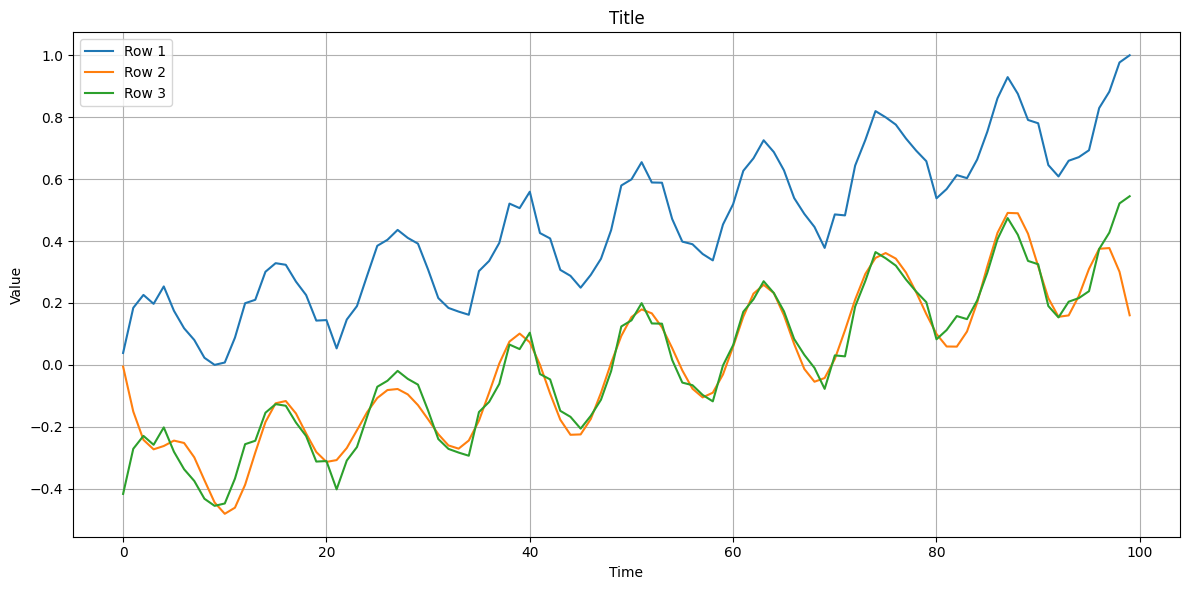

0.21273298876461555 0.05925361148664852 3.5902113546707644
0.01002376624301061 0.05925361148664852 0.1691671780254144


In [11]:
def dft_extract(data, n_freqs, fs=None, n=None, min_freq = None, max_freq = None, min_power_ratio = 1):
    
    if fs is None:
        fs = data.shape[0]
    if n is None:
        n = data.shape[0]
    
    # Compute DFT
    dft = np.fft.fft(data)
    magnitude = np.abs(dft)
    power = magnitude ** 2
    freq = np.fft.fftfreq(n, d=1/fs)

    # Filter frequencies by specified range
    pos_mask = freq > 0
    if min_freq is not None:
        pos_mask &= (freq >= min_freq)
    if max_freq is not None:
        pos_mask &= (freq <= max_freq)
        
    pos_freq = freq[pos_mask]
    pos_power = power[pos_mask]

    # Auto-select number of frequencies
    if n_freqs == 'auto':
        total_power = np.sum(pos_power)
        sorted_idx = np.argsort(pos_power)[::-1]
        cum_power = np.cumsum(pos_power[sorted_idx]) / total_power
        n_freqs = np.argmax(cum_power > min_power_ratio) + 1
    else:
        n_freqs = min(n_freqs, len(pos_freq))
        
    # Select most significant frequencies
    significant_idx = np.argpartition(pos_power, -n_freqs)[-n_freqs:]

    # Get the actual frequency indices in the original array
    original_indices = np.where(pos_mask)[0][significant_idx]

    # Reconstruct seasonal component
    reconstructed = np.zeros(n, dtype=complex)
    for idx in original_indices:
        freq_val = freq[idx]
        # Add positive frequency component
        reconstructed += (dft[idx] * np.exp(2j * np.pi * freq_val * np.arange(n) / n)) / n
        # Add negative frequency component (complex conjugate symmetric)
        if freq_val != 0 and freq_val != fs/2:
            neg_idx = n - idx 
            reconstructed += (dft[neg_idx] * np.exp(2j * np.pi * freq[neg_idx] * np.arange(n) / n)) / n

    seasonal = np.real(reconstructed)
    return seasonal

row = data1.copy()
row = (row - row.min())/(row.max() - row.min())
seasonal = dft_extract(row, 10, min_power_ratio=0.1)
plot_series([row, seasonal, row-row.mean()])

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def est_apr_dft(y_true, y_pred):
    # return (mean_absolute_error(y_true, y_pred) - y_true.min())/(y_true.max()-y_true.min())
    return mean_squared_error(y_true, y_pred)/y_true.max()

print(est_apr_dft(row, seasonal), np.var(row), est_apr_dft(row, seasonal)/np.var(row))
print(est_apr_dft(row-row.mean(), seasonal), np.var(row-row.mean()), est_apr_dft(row-row.mean(), seasonal)/np.var(row-row.mean()))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from scipy.signal import periodogram
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")

# Generate synthetic signal (sine wave + noise)
def generate_time_series(length=1000, noise_level=0.1, freq=2):
    t = np.arange(length)
    signal = np.sin(2 * np.pi * freq * t)
    noise = np.random.normal(0, noise_level, length)
    return signal + noise

# Example: Low vs. High noise
low_noise_series = generate_time_series(noise_level=0.05)
high_noise_series = generate_time_series(noise_level=0.5)

# plot_series([low_noise_series])
# plot_series([high_noise_series])

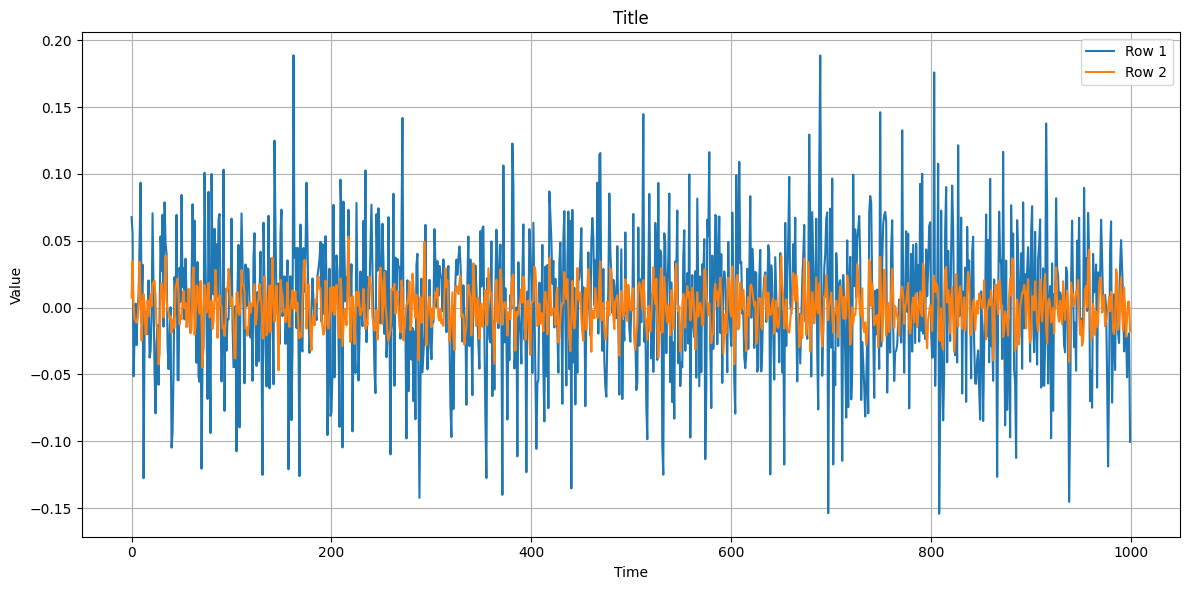

0.012761576608523393 0.002660423762734441 4.796821012982822
0.012890786983000908 0.002660423762734441 4.845388604464831


In [10]:
seasonal = dft_extract(low_noise_series, 10, min_power_ratio=0.5)
plot_series([low_noise_series, seasonal])

print(est_apr_dft(low_noise_series, seasonal), np.var(low_noise_series), est_apr_dft(low_noise_series, seasonal) / np.var(low_noise_series))
print(est_apr_dft(low_noise_series-low_noise_series.mean(), seasonal), np.var(low_noise_series), est_apr_dft(low_noise_series-low_noise_series.mean(), seasonal) / np.var(low_noise_series-low_noise_series.mean()))

In [34]:
def estimate_noise_diff(series):
    diff = np.diff(series)
    return np.var(diff) / 2

# Test
print("Diff-based noise estimate (Low):", estimate_noise_diff(low_noise_series))
print("Diff-based noise estimate (High):", estimate_noise_diff(high_noise_series))
estimate_noise_diff(data)

Diff-based noise estimate (Low): 0.0024349516882105175
Diff-based noise estimate (High): 0.25352233414923864


0.4319775968817018

In [36]:
def estimate_noise_mad(series):
    return 1.4826 * median_abs_deviation(series)

# Test
print("MAD noise estimate (Low):", estimate_noise_mad(low_noise_series))
print("MAD noise estimate (High):", estimate_noise_mad(high_noise_series))
estimate_noise_mad(data)

MAD noise estimate (Low): 0.048798247105274216
MAD noise estimate (High): 0.4992182698851522


3.9284468293574366

In [39]:
def estimate_noise_psd(series, threshold_freq=0.3):
    freqs, psd = periodogram(series)
    high_freq_mask = freqs > threshold_freq
    return np.mean(psd[high_freq_mask])

# Test
print("PSD high-freq energy (Low):", estimate_noise_psd(low_noise_series))
print("PSD high-freq energy (High):", estimate_noise_psd(high_noise_series))
estimate_noise_psd(data)

PSD high-freq energy (Low): 0.0048920113880250695
PSD high-freq energy (High): 0.5219030724067606


1.5005438480195779

In [13]:
# Create sample data
data = np.arange(100) 

analyze_series(data)

{'noise_level': 0.0, 'stationarity': 1.0, 'length': 100}

In [22]:
np.random.seed(25)

stationary_series = np.random.normal(0, 1, 500)
non_stationary_series = np.cumsum(np.random.normal(0, 1, 200))

analyze_series(stationary_series), analyze_series(non_stationary_series)

({'noise_level': 1.4309991087013523, 'stationarity': 0.0, 'length': 500},
 {'noise_level': 0.2565075531403856,
  'stationarity': 0.46745043537017084,
  'length': 200})

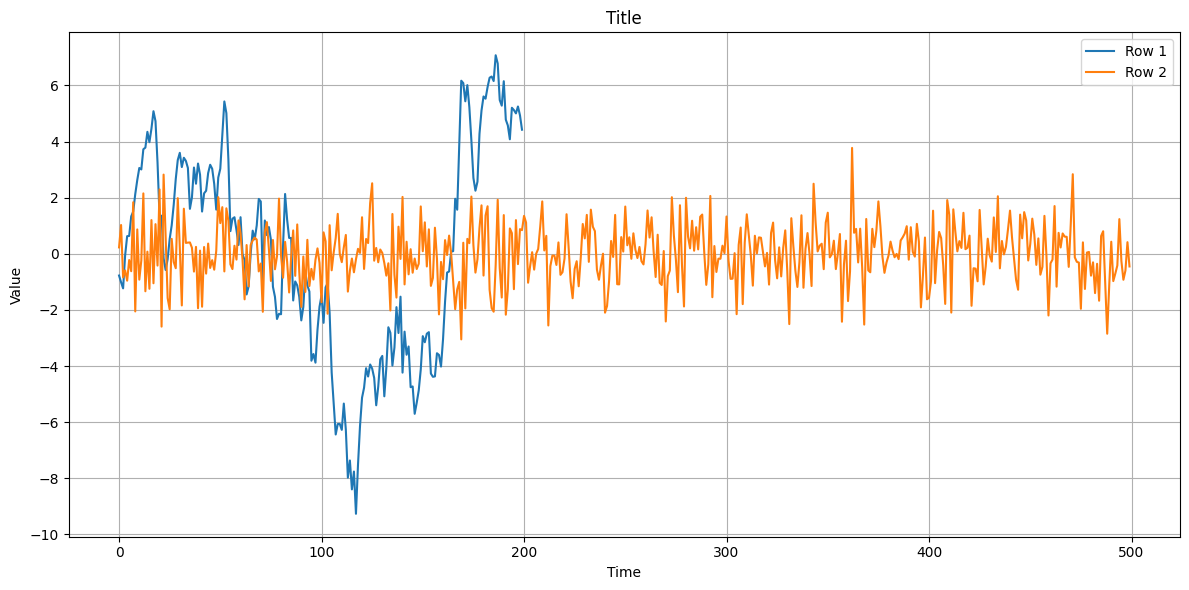

In [24]:
plot_series([non_stationary_series, stationary_series])

In [6]:

def generate_windows(
    series: np.ndarray,
    stationary_thresh: float = 0.05,
    noisy_thresh: float = 0.2,
) -> Dict[str, Dict[str, list]]:
    """
    Generate windows according to time format and statistical properties
    Returns JSON-serializable structure with windowed subsequences
    """
    properties = get_series_stats(series)
    time_format = detect_time_format(properties['length'])
    result = {'time_format': time_format, 'windows': {}}
    
    is_stationary = properties['stationarity'] < STATIONARY_THRESH
    is_noisy = properties['noise_level'] > NOISY_THRESH
    is_long = properties['length'] > LONG_THRESH
    
    if is_stationary or is_noisy or is_long:
        # Percentage-based windows for stationary/noisy/long series
        if time_format == 'm':
            window_percentages = [0.10, 0.15, 0.20, 0.30]
            stride_percentages = [0.10, 0.15, 0.20, 0.30]
        elif time_format == 'h':
            window_percentages = [0.05, 0.07, 0.10, 0.15]
            stride_percentages = [0.05, 0.10, 0.15, 0.20]
        else:  # 'd'
            window_percentages = [0.15, 0.25, 0.50]
            stride_percentages = [0.15, 0.25, 0.50]
        
        for wp, sp in zip(window_percentages, stride_percentages):
            window_size = max(2, int(properties['length'] * wp))
            stride = max(1, int(window_size * sp))
            key = f'window_{int(wp*100)}%_stride_{int(sp*100)}%'
            result['windows'][key] = [
                series[i:i+window_size].tolist()
                for i in range(0, len(series) - window_size + 1, stride)
            ]
    else:
        # Time-based meaningful windows
        if time_format == 'm':
            window_sizes = [6, 12, 24, 48, 72, 168]  # Hours in day/week
            strides = [3, 6, 12, 24, 24, 24]  # Half window strides
        elif time_format == 'h':
            window_sizes = [24, 24*3, 24*7, 24*30]  # Daily/weekly/monthly
            strides = [12, 24, 24*3, 24*7]  # Meaningful overlaps
        else:  # 'd'
            window_sizes = [7, 30, 90, 180]  # Weeks/months/quarters/half-years
            strides = [3, 15, 30, 60]  # Meaningful overlaps
        
        for ws, st in zip(window_sizes, strides):
            if ws < len(series):
                key = f'window_{ws}_stride_{st}'
                result['windows'][key] = [
                    series[i:i+ws].tolist()
                    for i in range(0, len(series) - ws + 1, st)
                ]
    
    return result